In [7]:
# base modules
import os
import sys
import copy
import logging

# custom module
from emlyon_module.imports import *
from emlyon_module.structured import *

# for manipulating data
from pandas_summary import DataFrameSummary
#!pip install dill
import dill

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
# !pip install -U plotnine
# from plotnine import ggplot, aes
# from plotnine.stats import stat_smooth
from pdpbox import pdp
import folium
# plotly
# seaborn
# altair


In [5]:
df_lapil42 = pd.read_csv('data/LAPIL42_final_selection.csv')

13

In [8]:
df_lapil42.isnull().sum()

speed                                        0
hour                                         0
TV/h                                         0
Dayofweek                                    0
PL/h                                         0
Vitesse du vent moyen 10 mn                  0
VL/h                                         0
Variation de pression en 3 heures            0
Etat du sol                                  0
Température                                  0
Température minimale du sol sur 12 heures    0
date                                         0
congestion+30min                             0
dtype: int64

In [10]:
df_lapil42 = df_lapil42.set_index(df_lapil42['date'])
df_lapil42

,speed,hour,TV/h,Dayofweek,PL/h,Vitesse du vent moyen 10 mn,VL/h,Variation de pression en 3 heures,Etat du sol,Température,Température minimale du sol sur 12 heures,date,congestion+30min
date,,,,,,,,,,,,,
2019-09-23 00:00:00,87.0,0,434.0,0,141.0,2.700000,293.0,80.000000,1.000000,287.950000,286.450000,2019-09-23 00:00:00,0
2019-09-23 00:06:00,87.0,0,434.0,0,141.0,2.672726,293.0,76.713049,0.997336,287.919104,286.424860,2019-09-23 00:06:00,1
2019-09-23 00:12:00,87.0,0,520.0,0,170.0,2.642294,350.0,73.491523,0.995162,287.886406,286.398089,2019-09-23 00:12:00,0
2019-09-23 00:18:00,87.0,0,520.0,0,170.0,2.608704,350.0,70.335422,0.993478,287.851905,286.369686,2019-09-23 00:18:00,0
2019-09-23 00:24:00,86.0,0,390.0,0,120.0,2.571957,270.0,67.244747,0.992285,287.815602,286.339653,2019-09-23 00:24:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-20 23:30:00,88.0,23,520.0,6,110.0,2.652161,410.0,201.973674,1.001384,283.560409,282.890517,2019-10-20 23:30:00,1
2019-10-20 23:36:00,85.0,23,690.0,6,140.0,2.650523,550.0,197.604785,1.001217,283.553549,282.858177,2019-10-20 23:36:00,1
2019-10-20 23:42:00,90.0,23,590.0,6,120.0,2.644488,470.0,193.222973,1.000995,283.549078,282.827955,2019-10-20 23:42:00,1


In [16]:
df, y, nas = proc_df(df_lapil42, 'congestion+30min')

In [17]:
def split_vals(df, n): 

    return df[:n].copy(), df[n:].copy()

In [18]:
n_total = len(df)
n_valid = int(0.33 * n_total)
n_train = n_total - n_valid
#n_small = 20000


X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

# X_small, _ = split_vals(df, n_small)
# y_small, _ = split_vals(y, n_small)

#print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of full training data points: X = (4503, 12), y = (4503,)
Number of validation data points: X = (2217, 12), y = (2217,)


In [65]:
model = LogisticRegression(penalty='l1', class_weight= 'balanced', solver= 'liblinear', random_state=42)

In [66]:
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [67]:
def specificity_score(y_true, y_predict):
    '''
    Computes the proba that a label is 0 knowing that the prediction is 0
    '''
    y_predict_0  = [(pred, true) for pred, true in zip(y_predict, y_true) if true == 0]
    y_predict_00 = [(pred, true) for pred, true in y_predict_0 if pred == 0]
    specificity  = (0 if len(y_predict_0) == 0 else len(y_predict_00)/len(y_predict_0))
    return specificity

In [68]:
y_predict_valid = model.predict(X_valid)

acc = metrics.accuracy_score(y_valid, y_predict_valid)
rec = metrics.recall_score(y_valid, y_predict_valid)
prc = metrics.precision_score(y_valid, y_predict_valid)
spe = specificity_score(y_valid, y_predict_valid)
f1  = metrics.f1_score(y_valid, y_predict_valid)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 92.42%
Recall : 82.29%
Precision : 74.57%
Specificity : 94.43%
F1-score : 78.24%


In [69]:
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas)
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(recall, precision)
    print('Area Under Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))

        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [70]:
# Le label prédit est 1 (Congestion) précisement quand sa probabilité estimée est >= 0.5
threshold = 0.5

probas_1 = model.predict_proba(X_valid)[:, 1]
prob_labels = [int(p > threshold) for p in probas_1]

pred_labels = model.predict(X_valid)

sum(prob_labels == pred_labels)/len(pred_labels)

1.0

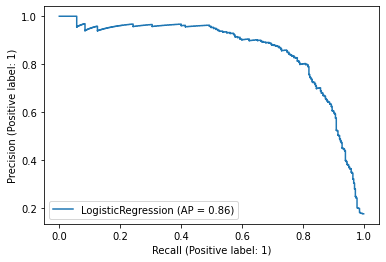

In [71]:
# beware that y axis is along [0.5, 1]
rec_prc_curve = metrics.plot_precision_recall_curve(model, X_valid, y_valid)
rec_prc_curve

In [72]:
y_predict_valid = model.predict(X_valid)

acc = metrics.accuracy_score(y_valid, y_predict_valid)
rec = metrics.recall_score(y_valid, y_predict_valid)
prc = metrics.precision_score(y_valid, y_predict_valid)
spe = specificity_score(y_valid, y_predict_valid)
f1  = metrics.f1_score(y_valid, y_predict_valid)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 92.42%
Recall : 82.29%
Precision : 74.57%
Specificity : 94.43%
F1-score : 78.24%


In [78]:
probs = model.predict_proba(X_valid)[:, 1] 
preds = [int(prob > 0.55) for prob in probs]
y_predict_valid = preds

acc = metrics.accuracy_score(y_valid, y_predict_valid)
rec = metrics.recall_score(y_valid, y_predict_valid)
prc = metrics.precision_score(y_valid, y_predict_valid)
spe = specificity_score(y_valid, y_predict_valid)
f1  = metrics.f1_score(y_valid, y_predict_valid)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 93.50%
Recall : 80.93%
Precision : 80.05%
Specificity : 96.00%
F1-score : 80.49%


In [ ]:
probas = model.predict_proba(X_valid)[:, 1]

precision_recall_curve_with_threshold(y_valid, probas, threshold = 0.35)

In [ ]:
probas = model.predict_proba(X_valid)[:, 1]

precision_recall_curve_with_threshold(y_valid, probas, threshold = 0.3)

In [ ]:
y_predict_valid = model.predict(X_valid)

report = metrics.classification_report(
    y_valid, 
    y_predict_valid, 
)
print(report)

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_predict_valid)
cm

array([[1800,   50],
       [  89,  278]], dtype=int64)

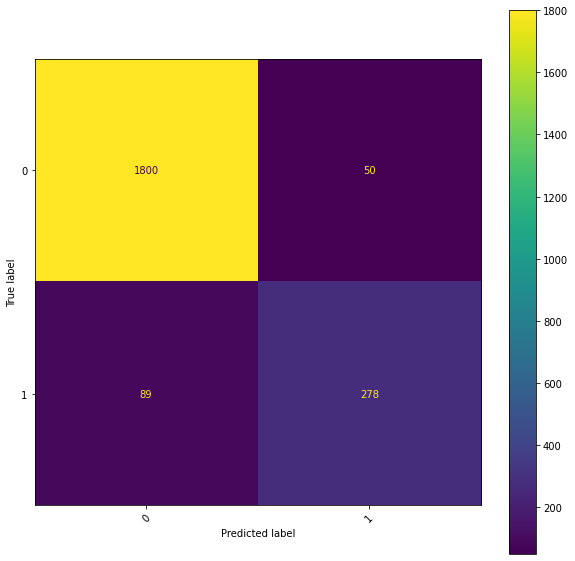

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

metrics.plot_confusion_matrix(
    model, 
    X_valid, 
    y_valid, 
    #display_labels = [str(interval) for interval in label_encoder.classes_.tolist()],
    include_values = True, 
    xticks_rotation = 45, 
    values_format = None, 
    cmap = 'viridis', 
    ax = ax,
    colorbar = True,
)